Dataset loaded successfully.
Initial DataFrame head:
       Tanggal     Produk  total_revenue  total_revenue_ema_10  \
0  2024-01-02  IQIYI VIP       233244.0         181412.000000   
1  2024-01-03  IQIYI VIP       310992.0         190836.000000   
2  2024-01-04  IQIYI VIP       336908.0         212682.545455   
3  2024-01-05  IQIYI VIP       142538.0         235268.991736   
4  2024-01-06  IQIYI VIP       207328.0         218408.811420   

   total_revenue_lag_1 revenue_class  
0             181412.0  Bad for Sale  
1             233244.0  Bad for Sale  
2             310992.0  Bad for Sale  
3             336908.0  Bad for Sale  
4             142538.0  Bad for Sale  

Initial DataFrame info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1360 entries, 0 to 1359
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Tanggal               1360 non-null   object 
 1   Produk                1360 non-

d:\Skripsi\Model Steps\Preprocessing\Step 1\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [09:18:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost model training complete.

--- Model Evaluation ---
Accuracy: 0.9890

Confusion Matrix:
 [[ 86   0   0]
 [  0 104   0]
 [  2   1  79]]

Classification Report:
                precision    recall  f1-score   support

 Bad for Sale       0.98      1.00      0.99        86
Good for Sale       0.99      1.00      1.00       104
  Normal Sale       1.00      0.96      0.98        82

     accuracy                           0.99       272
    macro avg       0.99      0.99      0.99       272
 weighted avg       0.99      0.99      0.99       272



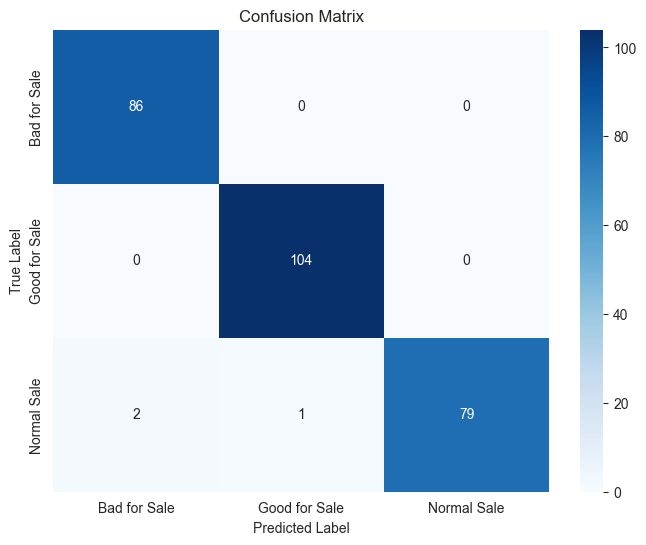

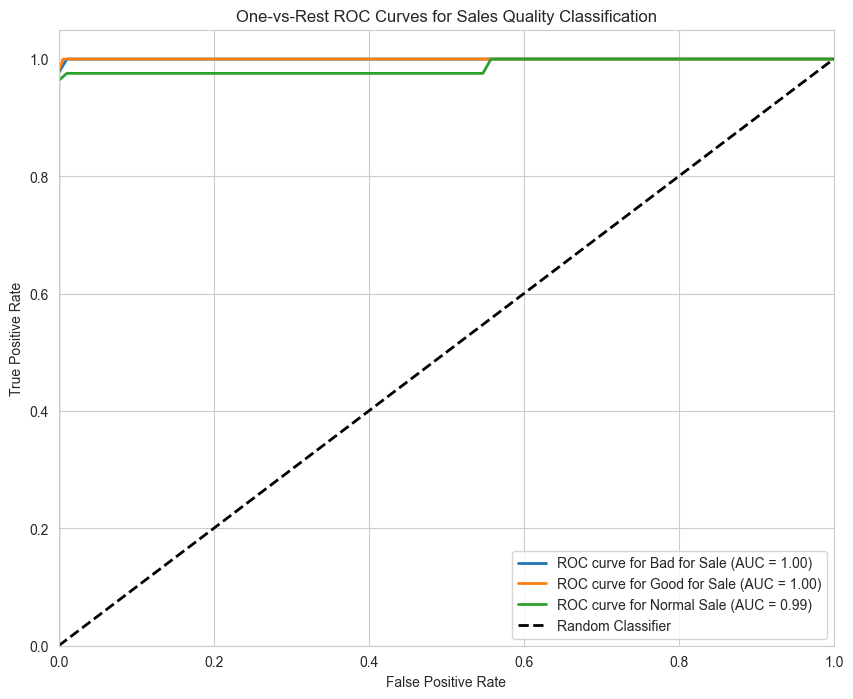

C:\Users\User\AppData\Local\Temp\ipykernel_9832\703846726.py:172: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances_sorted.values, y=feature_importances_sorted.index, palette='viridis')


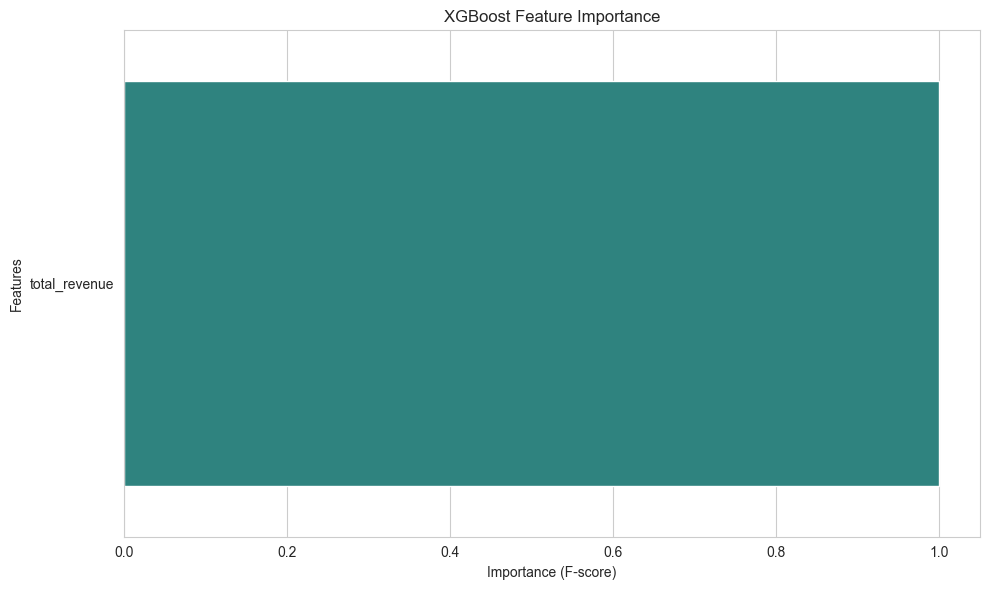

In [6]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split # Still import, but we'll use manually for chronological
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, label_binarize
import numpy as np

# --- Plotting Libraries ---
import matplotlib.pyplot as plt
import seaborn as sns

# Set a style for plots
sns.set_style("whitegrid")

# --- 1. Load the Dataset ---
try:
    df = pd.read_csv('final_dataset.csv')
    print("Dataset loaded successfully.")
    print("Initial DataFrame head:\n", df.head())
    print("\nInitial DataFrame info:\n")
    df.info()
except FileNotFoundError:
    print("Error: final_dataset.csv not found. Please make sure the file is in the correct directory.")
    exit()

# --- Preprocessing for Time-Series ---
# Ensure a 'Date' column exists and is in datetime format for chronological splitting
if 'Tanggal' not in df.columns:
    print("Error: 'Tanggal' column not found. A 'Tanggal' column is required for chronological splitting.")
    print("Please ensure your dataset contains a Tanggal/timestamp column.")
    exit()

df['Tanggal'] = pd.to_datetime(df['Tanggal'])
df = df.sort_values(by='Tanggal').reset_index(drop=True) # Sort by Tanggal and reset index
print("\nDataFrame sorted by Date.")


# --- 2. Verify and Encode the 'revenue_class' Target Variable ---
if 'revenue_class' not in df.columns:
    print("Error: 'revenue_class' column not found in the dataset.")
    print("Please ensure your preprocessing code that creates 'revenue_class' has been run and saved to 'final_dataset.csv'.")
    exit()

label_encoder = LabelEncoder()
df['revenue_class_encoded'] = label_encoder.fit_transform(df['revenue_class'])

label_encoder_mapping = {label: idx for idx, label in enumerate(label_encoder.classes_)}

target_names = label_encoder.classes_
num_classes = len(target_names)


# --- 3. Define Features (X) and Target (y) ---
features = [
    'total_revenue',
    # 'total_revenue_ema_7',
    # 'total_revenue_ema_10',
    # 'total_revenue_ema_14',
    # 'total_revenue_lag_1'
]

missing_features = [f for f in features if f not in df.columns]
if missing_features:
    print(f"\nError: The following specified features are missing from your dataset: {missing_features}")
    print("Please check your 'final_dataset.csv' columns.")
    exit()

X = df[features]
y = df['revenue_class_encoded']

# Handle NaN values after feature creation (e.g., from lags/EMAs)
# For time-series, dropping NaNs from the beginning is often the most direct approach.
# For 400 rows, losing a few rows is acceptable if it covers the NaN-generating period.
initial_rows_before_nan_drop = X.shape[0]
df_cleaned = pd.concat([X, y], axis=1).dropna() # Combine X and y to drop corresponding rows
X = df_cleaned[features]
y = df_cleaned['revenue_class_encoded']
rows_dropped = initial_rows_before_nan_drop - X.shape[0]

if rows_dropped > 0:
    print(f"\nWarning: {rows_dropped} rows dropped due to NaN values (likely from lag/EMA features).")
    print(f"Remaining dataset size after NaN handling: {X.shape[0]} rows.")


# --- 4. Chronological Split Data into Training and Testing Sets ---
# For a 400-row dataset, a common split could be 70-80% for training, 20-30% for testing.
# Let's aim for 80% training, 20% testing.
train_size = int(len(X) * 0.8) # 80% for training
print(f"\nTotal data points after NaN handling: {len(X)}")
print(f"Training set size: {train_size} rows")
print(f"Test set size: {len(X) - train_size} rows")


X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print(f"\nTraining set shape: {X_train.shape}, Test set shape: {X_test.shape}")
print(f"Training target distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Test target distribution:\n{y_test.value_counts(normalize=True)}")

print(f"\nLabel mapping: {list(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")

# --- 5. Train the XGBoost Classifier ---
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=num_classes,
    eval_metric='mlogloss',
    n_estimators=300,        # You might consider fewer estimators for smaller datasets
    learning_rate=0.05,
    max_depth=4,             # Keep max_depth relatively low to prevent overfitting
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    random_state=42
)

print("\nTraining XGBoost model...")
xgb_model.fit(X_train, y_train)
print("XGBoost model training complete.")

# --- 6. Make Predictions and Evaluate the Model ---
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test) # Get probabilities for ROC curve

print("\n--- Model Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=target_names))


# --- 7. Plotting Model Performance ---

# --- Plot 1: Confusion Matrix Heatmap ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# --- Plot 2: One-vs-Rest ROC Curve ---
# Binarize the output for multi-class ROC
y_test_bin = label_binarize(y_test, classes=range(num_classes))

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2,
             label=f'ROC curve for {target_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-Rest ROC Curves for Sales Quality Classification')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


# --- Plot 3: Feature Importance ---
feature_importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
feature_importances_sorted = feature_importances.sort_values(ascending=False)

xgb_model.save_model('xgb_model.json')  # Save the model for future use

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances_sorted.values, y=feature_importances_sorted.index, palette='viridis')
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance (F-score)')
plt.ylabel('Features')
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()